# Exploring Diffusion Models with JAX
In this notebook, we will be investigating the math and code behind the current hype surrounding diffusion models and exploring their effectiveness, applicability, and drawbacks. This topic is under active research so we will also be touching upon some optimizations that have been introduced recently.

### Table of Contents
* [1. Prerequisites and Setup](#req_setup)
* [2. Introduction](#introduction)
* [3. Diffusion Process](#diffusion_process)
    * [3.1. The Forward Pass](#the_forward_pass)
        * [3.1.1. Markov Chain](#markov_chain)
        * [3.1.2. Addition of Gaussian Noise](#addition_of_gaussian_noise)
        * [3.1.3. The Reparameterization Trick](#the_reparameterization_trick)
    * [3.2. The Backward Pass](#the_backward_pass)
        * [3.2.1. Autoencoders are back?](#autoencoders_are_back)
        * [3.2.2. Training Loop](#training_loop)
        * [3.2.3. Inference Loop](#inference_loop)
* [Improving the Inference Process with DDIMs](#improving_the_inference_process_with_ddims)
* [Conclusion](#conclusion)

## 1. Prerequisites and Setup <a class="anchor" id="req_setup"></a>

In [1]:
import jax
import optax
import math

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random as r
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import jax.numpy as jnp
import jax.random as random
import flax.linen as nn
from flax.training import train_state
import matplotlib.pyplot as plt

from typing import Callable
from tqdm.notebook import tqdm
from PIL import Image
from IPython import display


# Set only 80% of memory to be accessible. This avoids OOM due to pre-allocation.
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.8

# Prevent TFDS from using GPU
tf.config.experimental.set_visible_devices([], 'GPU')

# Defining some hyperparameters
NUM_EPOCHS = 2
BATCH_SIZE = 16
NUM_STEPS_PER_EPOCH = 60000//BATCH_SIZE # MNIST has 60,000 training samples

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.8


## 2. Introduction <a class="anchor" id="introduction"></a>

Diffusion models are based on the well researched concept of diffusion in physics.

In this context, diffusion is defined as the process by which an environment attempts to attain homogeneity by altering the potential gradient in response to the introduction of a new element. Diffusion as a notion is based on attaining uniformity in a system

<center><img src="https://i.imgur.com/unSQlrv.png" width=700px></center>

_But are the states of a diffusion process reversible? Can we identify these newly introduced particles in a homogeneous system?_  This is exactly what we try to do with diffusion models!

Consider that we have an image: we gradually add noise to the image in extremely small steps till we reach a stage ($T$) where the image is completely unrecognizable and becomes purely random noise.

<center><img src="https://i.imgur.com/sOauT6r.png" width=500px></center>

<br>
Once the forward "noise addition" chain $q$ is complete, we use a deep learning model with some trainable parameters $\theta$, to try and recover the image from the noise (denoising phase $p$) by estimating the noising chain at every timestep.
<br>

><b>Diffusion Task</b>:</br>
Gradually add noise to the image in $T$ steps in the forward process and try to recover the original image from the noisy image at $x_T$ in the backward process by tracing the chain backwards.


Diffusion was first introduced in [Deep Unsupervised Learning using Nonequilibrium Thermodynamics](https://arxiv.org/abs/1503.03585) (Sohl-Dickstein, et al, 2015) but was recently revived and developed by the researchers at Stanford and Google Brain. 

Diffusion models are typically classified into two types: continuous diffusion models and discrete diffusion models. In the forward chain, the former adds Gaussian noise to continuous signals, whilst the latter obfuscates discrete input tokens using a Markov Transition matrix. We'll look at the former in this post, understanding and implementing the equations from the [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (Ho et al, 2021) and [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502) (Song et al, 2021) papers in JAX.




## 3. Diffusion Process <a class="anchor" id="diffusion_process"></a>

### 3.1. The Forward Pass <a class="anchor" id="the_forward_pass"></a>
>The diffusion process is fixed to a **Markov chain** that gradually adds Gaussian noise to the data according to a **variance schedule** $\beta_1, \beta_2...\beta_T$ where $\beta_1<\beta_2...<\beta_T$

Let us break this sentence down:

#### 3.1.1. Markov Chain <a class="anchor" id="markov_chain"></a>

A Markov chain is a chain of events or states that follow the Markov principle. Markov's principle states that the distribution of a variable at an arbitrary point in the chain is determined only by the distribution of the previous state of the variable.

<center><img src="https://i.imgur.com/vXa2ifc.png" width=350px></center>

This means that the state of $x_1$ is only dependent on $x_0$. Similarly, the state of $x_2$ is only dependent on $x_1$ but since $x_1$ is dependent on $x_0$ any arbitrary state in the chain is indirectly dependent on all the states that occur before it.
The Markov's principle derives that the probability of occurrence of a chain of events from $x_1$ to $x_T$, given the first state, is as follows:

$$
q(x_{1:T} ∣x_0)=\prod_{t=1}^{T} q(x_t∣x_{t−1})
$$

The probability of a state $x_t$ given $x_{t-1}$ in our case is directly determined by the addition of noise since the amount of noise in the image at a given stage is only dependent on how much noise was previously existing.

#### 3.1.2. Addition of Gaussian Noise <a class="anchor" id="addition_of_gaussian_noise"></a>

As discussed above, we will need to calculate the probability of $q(x_t|x_{t-1})$ for generating an image at a given timestamp $T$. For this, we will need to sample some noise and incrementally add it to the image. 
Noise obtained from a Gaussian distribution only depends on two factors: the mean and the standard deviation (or variance). By changing these two values, it is possible to generate an infinite number of distributions of noise, one of which can then be added to the image at every step.

This is where the variance schedule $\beta_1, \beta_2...\beta_T$ comes into play. For diffusion models, we fix the variance schedule as we move along the chain. The sampling of noise at a given state can be defined as:

$$
q(x_t ∣ x_{t−1})=\mathcal{N}(x_t; \sqrt{1−\beta_t} x_{t−1},\beta_t I)
$$

The above line basically says that we have to generate a Gaussian distribution ($\mathcal{N}$) for $x_t$ by taking the value of $\sqrt{1-\beta_t} x_{t-1}$ as the mean and $\beta_t$ as the variance for that step. Combining this definition with the previous equation for $q(x_{1:T}|x_0)$, we can now sample the noise for any given step.


#### 3.1.3. The Reparameterization Trick <a class="anchor" id="the_reparameterization_trick"></a>

For our training task, the model, given the timestamp, is responsible to remove the added noise from the image at that timestamp. To generate a noisy image for the said timestamp, we will need to iterate through the entire chain. This is extremely inefficient because pythonic loops are slow and given a large timestamp, the chain may take too long to iterate over.
To avoid this, we use a reparameterization trick. It uses an approximation to generate the noise at the required timestamp. This approximation trick works because adding two Gaussians also results in a Gaussian. The reparameterized formula is given as below:

$$
\alpha_t:=1−β_t
$$

$$
\bar\alpha_t:=\prod_{s=1}^{T} \alpha_s
$$

$$
q(x_t ∣ x_0)=\mathcal{N}(x_t; \sqrt{\bar\alpha_t} x_0,(1−\bar\alpha_t)I)
$$

As compared to the previous equation, we can see that we have isolated the variance schedule and pre-calculated the cumulative product of this isolated variable $\alpha_t$. Using this equation, we can now directly sample the noisy image at any time step with just the original image ($x_0$). 

Let us now define the code for this:

In [2]:
# Load MNIST dataset

def get_datasets():
  # Load the MNIST dataset
  train_ds = tfds.load('mnist', as_supervised=True, split="train")
  
  # Normalization helper
  def preprocess(x, y):
    return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (32, 32))
  
  # Normalize to [-1, 1], shuffle and batch
  train_ds = train_ds.map(preprocess, tf.data.AUTOTUNE)
  train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  
  # Return numpy arrays instead of TF tensors while iterating
  return tfds.as_numpy(train_ds)


train_ds = get_datasets()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


The forward pass algorithm can be written as:

1. Define the total timesteps ($T$) for the chain 
2. Generate $\beta$, $\alpha$ and $\bar\alpha$ for every $t \in T$
3. Generate noise according to $q(x_t|x_0) = \mathcal{N}(x_t; \sqrt{\bar\alpha_t} x_{0}, (1-\bar\alpha_t)I)$

In [3]:
# Defining a constant value for T
timesteps = 200

# Defining beta for all t's in T steps
beta = jnp.linspace(0.0001, 0.02, timesteps)

# Defining alpha and its derivatives according to reparameterization trick
alpha = 1 - beta
alpha_bar = jnp.cumprod(alpha, 0)
alpha_bar = jnp.concatenate((jnp.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = jnp.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = jnp.sqrt(1 - alpha_bar)

# Implement noising logic according to reparameterization trick
def forward_noising(key, x_0, t):
  noise = random.normal(key, x_0.shape)  
  reshaped_sqrt_alpha_bar_t = jnp.reshape(jnp.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
  reshaped_one_minus_sqrt_alpha_bar_t = jnp.reshape(jnp.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
  noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
  return noisy_image, noise

Let us visualize how the image looks at some timestamps:


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

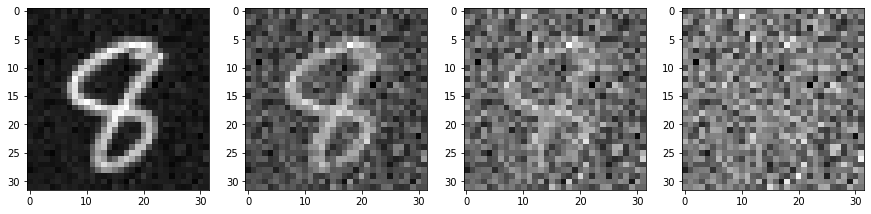

In [4]:
# Let us visualize the output image at a few timestamps
sample_mnist = next(iter(train_ds))[0]

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([10, 50, 100, 185]):
  noisy_im, noise = forward_noising(random.PRNGKey(0), jnp.expand_dims(sample_mnist, 0), jnp.array([i,]))
  plt.subplot(1, 4, index+1)
  plt.imshow(jnp.squeeze(jnp.squeeze(noisy_im, -1),0), cmap='gray')

plt.show()

As we can see, the number gets progressively difficult to identify as T increases. At $t=185$, the number is almost completely indistinguishable from the added noise.

### 3.2 The Backward Pass <a class="anchor" id="the_backward_pass"></a>

The backward pass aims to turn the noisy image into the desired domain distribution, whether it be for denoising, image super-resolution, or just about anything else!

#### 3.2.1. Autoencoders are back? <a class="anchor" id="autoencoders_are_back"></a>

For the backward denoising part, we can use any model with a large enough capacity. Usually, papers tend to use autoencoders like U-Nets with global attention which are mathematically and experimentally proved to be performant for tasks such as generation and segmentation. The only difference between the U-Net model used for diffusion and a standard attention augmented U-Net is the additional timestamp information that is integrated into the model as well. 

<center><img src="https://i.imgur.com/jrL66R5.png" width=450px></center>

The above diagram compares a standard U-Net to the modified U-Net that integrates the information provided by the timestamp. The timestamp is first embedded into a N-dimensional vector and is then added to every layer in the model so that the model can learn the correlation between the noise and the timestamp and de-noise accordingly.
But wait! Do you notice something weird? The model takes in the timestamp and the noisy image as input and outputs *noise*?

Yes! Commonly adopted diffusion models output noise but that doesn't mean you cannot directly output the image. The model's aim is to output the noise distribution it believes is present in the picture, and this is done only for the sake of convenience. If we output the noise, we can simplify the loss calculation which makes the process more comprehensible.


For diffusion tasks in general, authors of [Pseudo Numerical Methods for Diffusion Models on Manifolds](https://arxiv.org/abs/2202.09778) (Liu et al, 2021) explained that models with increased width reach the desired sample quality faster than models with increased depth.


Before we define the model itself, let us define how the time must be embedded into the model. We use the popular sinusoidal projection which is also commonly used in positional encodings in transformers. We project the time constant into a defined dimensional space (in our case, 128 dimensional) which we will integrate into the model later. Let us code this:

In [5]:
class SinusoidalEmbedding(nn.Module):
  dim: int = 32
  
  @nn.compact
  def __call__(self, inputs):
    half_dim = self.dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = jnp.exp(jnp.arange(half_dim) * -emb)
    emb = inputs[:, None] * emb[None, :]
    emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], -1)
    return emb


class TimeEmbedding(nn.Module):
  dim: int = 32
  @nn.compact
  def __call__(self, inputs):
    time_dim = self.dim * 4
    
    se = SinusoidalEmbedding(self.dim)(inputs)
    
    # Projecting the embedding into a 128 dimensional space
    x = nn.Dense(time_dim)(se)
    x = nn.gelu(x)
    x = nn.Dense(time_dim)(x)
    
    return x

The U-Net architecture was first proposed in [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) (Olaf Ronneberger et al, 2015). The reasoning for this type of architecture was to create a bottleneck representation with continuous downsampling convolutional blocks before upsampling instead of just stacking convolutional layers. This network structure has been a standard not only for medical segmentation tasks but was later improvised for generalized super-resolution and generation.

<center><img src="https://i.imgur.com/dN69cmI.png" width=450px></center>

We will be using a modified version of the U-Net that uses ResNet blocks instead of simple convolutional blocks. This U-Net will incorporate the time embedding and an additional attention mechanism in every block.

In [6]:
# Standard dot-product attention with eight heads.
class Attention(nn.Module):
    dim: int
    num_heads: int = 8
    use_bias: bool = False
    kernel_init: Callable = nn.initializers.xavier_uniform()

    @nn.compact
    def __call__(self, inputs):
        batch, h, w, channels = inputs.shape
        inputs = inputs.reshape(batch, h*w, channels)
        batch, n, channels = inputs.shape
        scale = (self.dim // self.num_heads) ** -0.5
        qkv = nn.Dense(
            self.dim * 3, use_bias=self.use_bias, kernel_init=self.kernel_init
        )(inputs)
        qkv = jnp.reshape(
            qkv, (batch, n, 3, self.num_heads, channels // self.num_heads)
        )
        qkv = jnp.transpose(qkv, (2, 0, 3, 1, 4))
        q, k, v = qkv[0], qkv[1], qkv[2]

        attention = (q @ jnp.swapaxes(k, -2, -1)) * scale
        attention = nn.softmax(attention, axis=-1)

        x = (attention @ v).swapaxes(1, 2).reshape(batch, n, channels)
        x = nn.Dense(self.dim, kernel_init=nn.initializers.xavier_uniform())(x)
        x = jnp.reshape(x, (batch, int(x.shape[1]** 0.5), int(x.shape[1]** 0.5), -1))
        return x

Let us now define a standard ResNet block which will be the basic building block for our U-Net.

The original ResNet block consisted of Convolutional and BatchNorm layers stacked on top of each other. For our implementation, we will replace the BatchNorm with GroupNorm, each consisting of eight groups. Each ResNet block includes a time embedding projection.

The general implementation diagram is as follows:

<center><img src="https://i.imgur.com/pyGbq19.png" width=250px></center>

In [7]:
class Block(nn.Module):
  dim: int = 32
  groups: int = 8

  @nn.compact
  def __call__(self, inputs):
    conv = nn.Conv(self.dim, (3, 3))(inputs)
    norm = nn.GroupNorm(num_groups=self.groups)(conv)
    activation = nn.silu(norm)
    return activation


class ResnetBlock(nn.Module):
  dim: int = 32
  groups: int = 8

  @nn.compact
  def __call__(self, inputs, time_embed=None):
    x = Block(self.dim, self.groups)(inputs)
    if time_embed is not None:
      time_embed = nn.silu(time_embed)
      time_embed = nn.Dense(self.dim)(time_embed)
      x = jnp.expand_dims(jnp.expand_dims(time_embed, 1), 1) + x
    x = Block(self.dim, self.groups)(x)
    res_conv = nn.Conv(self.dim, (1, 1), padding="SAME")(inputs)
    return x + res_conv

Finally, we define the U-Net with the dot product attention and ResNet blocks created above. For our toy task of MNIST digit generation, we will use a U-Net with a 32 dimensional width.

In [8]:
class UNet(nn.Module):
  dim: int = 8
  dim_scale_factor: tuple = (1, 2, 4, 8)
  num_groups: int = 8


  @nn.compact
  def __call__(self, inputs):
    inputs, time = inputs
    channels = inputs.shape[-1]
    x = nn.Conv(self.dim // 3 * 2, (7, 7), padding=((3,3), (3,3)))(inputs)
    time_emb = TimeEmbedding(self.dim)(time)
    
    dims = [self.dim * i for i in self.dim_scale_factor]
    pre_downsampling = []
    
    # Downsampling phase
    for index, dim in enumerate(dims):
      x = ResnetBlock(dim, self.num_groups)(x, time_emb)
      x = ResnetBlock(dim, self.num_groups)(x, time_emb)
      att = Attention(dim)(x)
      norm = nn.GroupNorm(self.num_groups)(att)
      x = norm + x
      # Saving this output for residual connection with the upsampling layer
      pre_downsampling.append(x)
      if index != len(dims) - 1:
        x = nn.Conv(dim, (4,4), (2,2))(x)
    
    # Middle block
    x = ResnetBlock(dims[-1], self.num_groups)(x, time_emb)
    att = Attention(dim)(x)
    norm = nn.GroupNorm(self.num_groups)(att)
    x = norm + x 
    x = ResnetBlock(dims[-1], self.num_groups)(x, time_emb)
    
    # Upsampling phase
    for index, dim in enumerate(reversed(dims)):
      x = jnp.concatenate([pre_downsampling.pop(), x], -1)
      x = ResnetBlock(dim, self.num_groups)(x, time_emb)
      x = ResnetBlock(dim, self.num_groups)(x, time_emb)
      att = Attention(dim)(x)
      norm = nn.GroupNorm(self.num_groups)(att)
      x = norm + x
      if index != len(dims) - 1:
        x = nn.ConvTranspose(dim, (4,4), (2,2))(x)


    # Final ResNet block and output convolutional layer
    x = ResnetBlock(dim, self.num_groups)(x, time_emb)
    x = nn.Conv(channels, (1,1), padding="SAME")(x)
    return x

model = UNet(32)

#### 3.2.2. Training Loop <a class="anchor" id="training_loop"></a>

The standard equation for the backward pass can be given as:

$$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t),\sum_\theta(x_t, t))$$

Here, we aim to generate the noise when going from a state $x_t$ to $x_{t-1}$ according to the mean $\mu_\theta$ and standard deviation distribution $\sum_\theta$ generated by the model. Researchers found that fixing the value of the variance to the value of $\beta_t$ helps the model produce better outputs. Though this is still under active experimentation, we will go ahead and assume the output variance to be set as $\beta_t$.

Now that we have defined what we need to do, let us define the loss function. The loss function used for diffusion models is derived from the ELBO loss commonly used with variational autoencoders. This loss defines a lower bound objective and a simplified version of the objective can be given as:

$$Loss_{simplified}(\theta) = \mathbb{E_{t, x_0, \epsilon}}[||\epsilon - \epsilon_\theta(\sqrt{\bar\alpha_t} x_{0}+ \sqrt{1-\bar\alpha_t}\epsilon,t)||^2] \hspace{0.5cm} \epsilon \in \mathcal{N}(0, I)$$

The descent function takes three inputs: the timestamp ($t$), the original image ($x_0$), and some randomly generated Gaussian noise that is to be added to the original image ($\epsilon$). The model then generates the noise in the forward-propagation step that it thinks is added to the image and we calculate the mean squared error between the model output noise and the original noise. This loss value is then used to calculate the gradients and backpropagate through the autoencoder model.

In [9]:
# Calculate the gradients and loss values for the specific timestamp
@jax.jit
def apply_model(state, noisy_images, noise, timestamp):
  """Computes gradients and loss for a single batch."""
  def loss_fn(params):
    
    # Take the prediction from the model
    pred_noise = model.apply({'params': params}, [noisy_images, timestamp])
    
    # Calculate and return the MSE value
    loss = jnp.mean((noise - pred_noise) ** 2)
    return loss

  
  # Calculate gradients w.r.t loss function and return the loss value and gradients
  grad_fn = jax.value_and_grad(loss_fn, has_aux=False)
  loss, grads = grad_fn(state.params)
  return grads, loss


# Helper function for applying the gradients to the model
@jax.jit
def update_model(state, grads):
  """Applies gradients to the model"""
  return state.apply_gradients(grads=grads)

The training step performs the following functions:

1. Generate random PRNGKeys for generating the timestamps and noise
2. Generate the noisy images
3. Forward propagate on the UNet
4. Update the model weights in the backward propagation process according to the calculated gradients
5. Display loss at that particular step and return the current state and loss

In [10]:
# Define the training step
def train_epoch(epoch_num, state, train_ds, batch_size, rng):

  epoch_loss = []

  for index, batch_images in enumerate(tqdm(train_ds)):
    # Creating two keys: one for timestamp generation and second for generating the noise
    rng, tsrng = random.split(rng)
    
    # Generating timestamps for this batch
    timestamps = random.randint(tsrng, 
                                shape=(batch_images.shape[0],), 
                                minval=0, maxval=timesteps)
    
    # Generating the noise and noisy image for this batch
    noisy_images, noise = forward_noising(rng, batch_images, timestamps)
    
    # Forward propagation
    grads, loss = apply_model(state, noisy_images, noise, timestamps)
    
    # Backpropagation
    state = update_model(state, grads)
    
    # Loss logging
    epoch_loss.append(loss)
    if index % 100 == 0:
      print(f"Loss at step {index}: ", loss)
    
    # Timestamps are not needed anymore. Saves some memory.
    del timestamps 
  
  train_loss = np.mean(epoch_loss)


  return state, train_loss

Creating a train state for training. This training state contains the optimizer state and model weights (params). These will be updated after every descent step

In [11]:
from flax.training import train_state

def create_train_state(rng):
  """Creates initial `TrainState`."""
  
  # Initializing model parameters
  params = model.init(rng, [jnp.ones([1, 32, 32, 1]), jnp.ones([1,])])['params']
  
  # Initializing the Adam optimizer
  tx = optax.adam(1e-4)
  
  # Return the training state  
  return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

Before we start the training process, we will define the logic for training which goes as follows:

1. Generate a PRNGKey which will be used to initialize the weights
2. Create a training state for our model using the helper function defined before
3. Iterate over `NUM_EPOCHS` and for each epoch, call the `train_epoch()` function.
4. Log the state at the end of the epoch for future reference (This is optional)

In [12]:
log_state = []

def train(train_ds) -> train_state.TrainState:
  # Create the master key
  rng = jax.random.PRNGKey(0)
  
  # Split the master key into subkeys
  # These will be used for weight init, and noise and timestamp generation later
  rng, init_rng = jax.random.split(rng)
    
  # Create training state  
  state = create_train_state(init_rng)
  
  # Start training
  for epoch in range(1, NUM_EPOCHS + 1):
    # Generate subkeys for noise and timestamp generation
    rng, input_rng = jax.random.split(rng)
    
    # Call train epoch function
    state, train_loss = train_epoch(epoch, state, train_ds, BATCH_SIZE, input_rng)
    
    # Print output loss and log the state at the end of every epoch
    print(f"Training loss after epoch {epoch}: ", train_loss)
    log_state.append(state) # Optional

  return state

All that is left to do now is to pass the training dataset to this function and start training!

In [13]:
trained_state = train(train_ds)

  0%|          | 0/3750 [00:00<?, ?it/s]

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 0:  5.628031


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 100:  0.5477305


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 200:  0.31860447


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 300:  0.19363695


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 400:  0.23898092


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 500:  0.22366914


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 600:  0.23465641


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 700:  0.1641595


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 800:  0.18584841


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 900:  0.100633174


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1000:  0.16690156


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1100:  0.08517057


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1200:  0.20500514


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1300:  0.123595804


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1400:  0.16773081


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1500:  0.1574075


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1600:  0.08918853


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1700:  0.1475496


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1800:  0.085143104


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 1900:  0.11026095


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2000:  0.07677067


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2100:  0.08525561


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2200:  0.09555927


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2300:  0.08157772


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2400:  0.060384277


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2500:  0.08370224


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2600:  0.19088994


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2700:  0.12007946


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2800:  0.05636227


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 2900:  0.051268313


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 3000:  0.13228014


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 3100:  0.060722277


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 3200:  0.04853122


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 3300:  0.14466771


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 3400:  0.05462895


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Loss at step 3500:  0.068982996
Loss at step 3600:  0.057332136
Loss at step 3700:  0.06462496
Training loss after epoch 1:  0.14658196


  0%|          | 0/3750 [00:00<?, ?it/s]

Loss at step 0:  0.06991187
Loss at step 100:  0.09055138
Loss at step 200:  0.046069786
Loss at step 300:  0.08148168
Loss at step 400:  0.054555982
Loss at step 500:  0.083556496
Loss at step 600:  0.05856786
Loss at step 700:  0.06221777
Loss at step 800:  0.06382249
Loss at step 900:  0.03619022
Loss at step 1000:  0.04581818
Loss at step 1100:  0.06905861
Loss at step 1200:  0.056239862
Loss at step 1300:  0.04322113
Loss at step 1400:  0.038928576
Loss at step 1500:  0.057445645
Loss at step 1600:  0.052342407
Loss at step 1700:  0.051008157
Loss at step 1800:  0.044352174
Loss at step 1900:  0.042237807
Loss at step 2000:  0.04390324
Loss at step 2100:  0.05366376
Loss at step 2200:  0.1020824
Loss at step 2300:  0.065048546
Loss at step 2400:  0.048526023
Loss at step 2500:  0.055360995
Loss at step 2600:  0.037210826
Loss at step 2700:  0.09779158
Loss at step 2800:  0.0433504
Loss at step 2900:  0.040703632
Loss at step 3000:  0.03438461
Loss at step 3100:  0.04293549
Loss at

#### 3.2.3. Inference Loop <a class="anchor" id="inference_loop"></a>

After successfully completing the training process, we must define an inference loop that can generate new samples for us when provided with Gaussian noise as input. The general algorithm for sampling is given as follows:

<center><img src="https://i.imgur.com/jFkkmXc.png" width=400px></center>

Let us run through a loop of sampling. We first sample a random noise that we assume is the $x_T$ step image. Then, we simply loop backward from $T$ to $1$ where we sample the image according to the following formula:
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\bar\alpha_t}} \epsilon_\theta(x_t, t)) + \sigma_t z$$

This essentially indicates that we utilize the model's mean and set standard deviation to $\sqrt{\beta_t}$.

In [14]:
# This function defines the logic of getting x_t-1 given x_t
def backward_denoising_ddpm(x_t, pred_noise, t):
  alpha_t = jnp.take(alpha, t)
  alpha_t_bar = jnp.take(alpha_bar, t)
  
  eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5  
  mean = 1 / (alpha_t ** 0.5) * (x_t - eps_coef * pred_noise)
  
  var = jnp.take(beta, t)
  z = random.normal(key=random.PRNGKey(r.randint(1, 100)), shape=x_t.shape)

  return mean + (var ** 0.5) * z

The following code will generate a sample image and save a GIF of the process. Note that because of the $T=200$ iterations, the generation will take around 10 minutes for a single image. You are free to change the PRNGKey to see different digit generations.

In [15]:
# Save a GIF using logged images

def save_gif(img_list, path=""):
    # Transform images from [-1,1] to [0, 255]
    imgs = (Image.fromarray(np.array((np.array(i) * 127.5) + 1, np.int32)) for i in img_list)

    # Extract first image from iterator
    img = next(imgs)  

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

  0%|          | 0/199 [00:00<?, ?it/s]

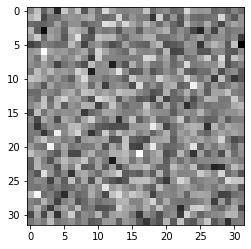

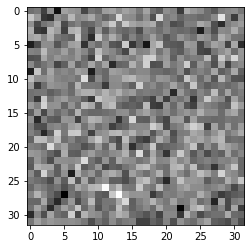

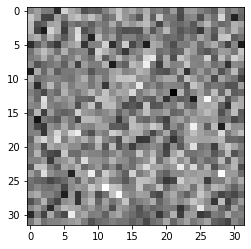

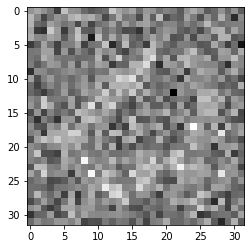

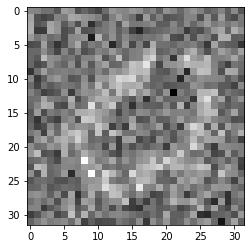

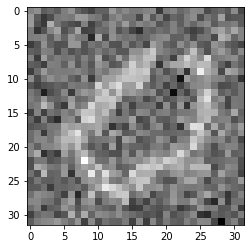

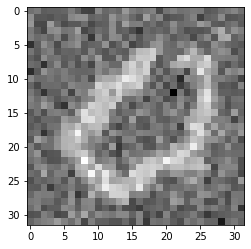

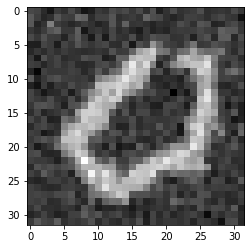

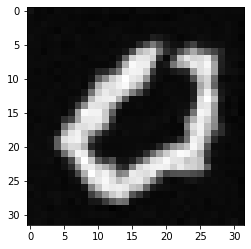

In [16]:
# Generating Gaussian noise
x = random.normal(random.PRNGKey(42), (1, 32, 32, 1))

trained_state = log_state[-1]

# Create a list to store output images
img_list_ddpm = []

# Append the initial noise to the list of images
img_list_ddpm.append(jnp.squeeze(jnp.squeeze(x, 0),-1))

# Iterate over T timesteps
for i in tqdm(range(0, timesteps - 1)):
  # t-th timestep  
  t = jnp.expand_dims(jnp.array(timesteps - i - 1, jnp.int32), 0)
  
  # Predict noise using U-Net
  pred_noise = model.apply({'params': trained_state.params}, [x, t])
  
  # Obtain the output from the noise using the formula seen before
  x = backward_denoising_ddpm(x, pred_noise, t)

  # Log the image after every 25 iterations
  if i % 25 == 0:
    img_list_ddpm.append(jnp.squeeze(jnp.squeeze(x, 0),-1))
    plt.imshow(jnp.squeeze(jnp.squeeze(x, 0),-1), cmap='gray')
    plt.show()

# Display the final generated image
plt.imshow(jnp.squeeze(jnp.squeeze(x, 0),-1), cmap='gray')
plt.show()

# Save generated GIF
save_gif(img_list_ddpm, path="output_ddpm.gif")

In [17]:
# Display GIF
display.Image(url='output_ddpm.gif', width=128, height=128)

## 4. Improving the Inference Process with DDIMs <a class="anchor" id="improving_the_inference_process_with_ddims"></a>

A major problem with the inference process above is that although we train with an $x_t$ to predict $x_0$, we have to iterate over all $T$ steps for inference. This can take over a day to generate 50,000, 32 $\times$ 32 images. This is where [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502) (Song et al, 2021) come into picture.

The paper proposes a method to make the backward de-noising process non-Markovian, which means that the order of chain does not have to necessarily only depend on the previous image. The paper modifies the DDPM objective to propose a more general loss function:

$$Loss_{\gamma} = \mathbb{\gamma_t E_{t, x_0, \epsilon}}[||\epsilon - \epsilon_\theta(\sqrt{\bar\alpha_t} x_{0}+ \sqrt{1-\bar\alpha_t}\epsilon,t)||^2] \hspace{0.5cm} \epsilon \in \mathcal{N}(0, I)$$

The authors observed that $L_{\gamma}$ only depends on $q(x_t|x_0)$ but not directly on the joint probability $q(x_{1:T}|x_0)$. Because there can be many inference distributions with the same marginals, they proposed that we could explore an alternate inference process that is non-Markovian which leads to a new generative process that leads to the same objective.

$$q_\sigma(x_{1:T} | x0) := q_\sigma(x_T |x_0)\prod_{t=2}^{T} q_\sigma(x_{t−1}|x_t, x_0)$$

$$\text{where} \hspace{0.1cm} q_\sigma(x_T |x_0) = \mathcal{N}(\sqrt{\alpha_T}x_0, (1 − \alpha_T)I) \hspace{0.1cm} \text{for all} \hspace{0.1cm} t > 1,$$


$$
q_\sigma(x_{t-1}|x_t, x_0) = \mathcal{N} (\sqrt{\alpha_{t-1}}x_0 + \sqrt{1-\alpha_{t-1} - \sigma_t^2} . \frac{x_t - \sqrt{\alpha_t} x_0}{\sqrt{1- \alpha_t}} , \sigma_t^2I)
$$

As observed above, while changing the backward process to a non-Markovian, we make the forward process non-Markovian as well where $\sigma$ controls the stochasticity of the forward process. When $\sigma \to 0$, we reach a case where $x_{t-1}$ becomes known and fixed.


For the generative process with a fixed prior $p_\theta(x_T) = \mathcal{N}(0,I)$, 

$$
p_\theta^{(t)} (x_{t-1}|x_t) = \begin{cases}
\mathcal{N}(f_\theta^{(1)} (x_1), \sigma_1^2 I ) & \text{if t=1}\\
q_\sigma(x_{t-1}|x_t, f_\theta^{(t)} (x_t)) & \text{otherwise}
\end{cases}
$$

$$\text{Here, } f_\theta^{(t)}(x_t) := \frac{x_t - \sqrt{1-\bar\alpha_t} . \epsilon_\theta^{(t)} (x_t)}{\sqrt{\bar\alpha_t}}$$


Hence, the equation we use for inference is given as:

$$
x_{t-1} = \sqrt{\alpha_{t-1}} \underbrace{ \left(\frac{x_t - \sqrt{1-\bar\alpha_t}\epsilon_\theta^{(t)}}{\sqrt{\bar\alpha_t}} \right)}_{\text{predicted} \hspace{0.1cm} x_0} + \underbrace{\sqrt{1-\alpha_{t-1} - \sigma_t^2}.\epsilon_{\theta}^{(t)}(x_t)}_{\text{direction pointing to} \hspace{0.1cm} x_t} + \underbrace{\sigma_t \epsilon_t}_{\text{random noise}}
$$

Notice that if we set $\sigma_t = \sqrt{(1-\alpha_{t-1})/(1-\bar\alpha_t)} \sqrt{1-\bar\alpha_t/\alpha_{t-1}} \hspace{0.1cm} \text{for all} \hspace{0.1cm} t$, the forward process becomes Markovian and the generative process becomes a DDPM. But if we set $\sigma_t = 0 \hspace{0.1cm} \text{for all} \hspace{0.1cm} t$ then the forward process becomes deterministic. This type of model is called a ***Denoising Diffusion Implicit Model (DDIM)***.

Note that we do not have to change the training process of the model. With just a change in the backward de-noising procedure, we can see that this technique can reduce 200 iterations to just 10 or even as less as 4 iterations. 

In [18]:
# This function takes an additional sigma_t parameter which is set to 0 for DDIMs
def backward_denoising_ddim(x_t, pred_noise, t, sigma_t):
  alpha_bar_t = jnp.take(alpha_bar, t)
  alpha_t_minus_one = jnp.take(alpha, t - 1)
    
  # predicted x_0
  pred = (x_t - ((1 - alpha_bar_t) ** 0.5) * pred_noise)/ (alpha_bar_t ** 0.5)
  pred = (alpha_t_minus_one ** 0.5) * pred
    
  # direction pointing to x_t
  pred = pred + ((1 - alpha_t_minus_one - (sigma_t ** 2)) ** 0.5) * pred_noise
  
  # random noise
  eps_t = random.normal(key=random.PRNGKey(r.randint(1, 100)), shape=x_t.shape)
  pred = pred + (sigma_t * eps_t)
  
  return pred

  0%|          | 0/10 [00:00<?, ?it/s]

[180]


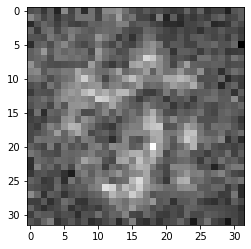

[160]


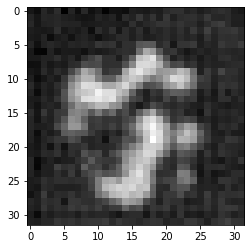

[140]


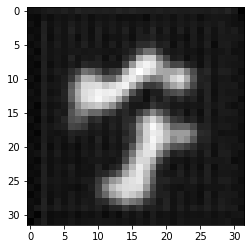

[120]


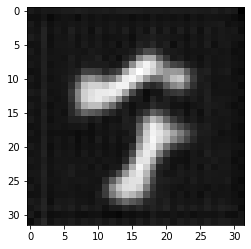

[100]


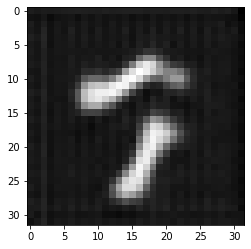

[80]


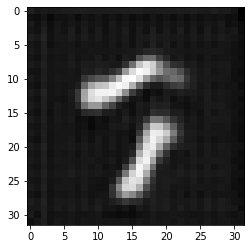

[60]


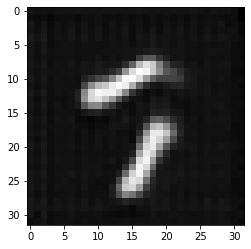

[40]


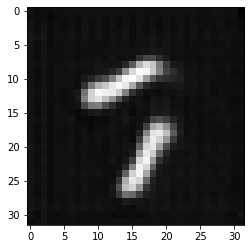

[20]


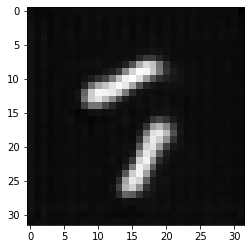

[0]


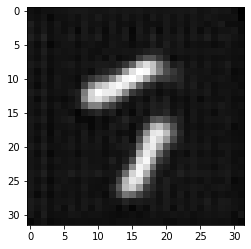

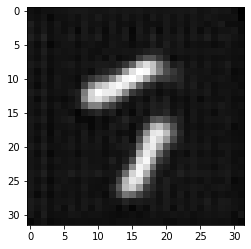

In [19]:
# Create a list to store output images
img_list_ddim = []

# Extract the weights from the final trained state 
trained_state = log_state[-2]
params = trained_state.params

# Generate some noise
x = random.normal(random.PRNGKey(42), (1, 32, 32, 1))

# Append noise to image list
img_list_ddim.append(jnp.squeeze(jnp.squeeze(x, 0),-1))

# Define number of inference loops to run
inference_timesteps = 10

# Create a range of inference steps that the output should be sampled at
inference_range = range(0, timesteps, timesteps // inference_timesteps)

# Iterate over inference_timesteps
for index, i in tqdm(enumerate(reversed(range(inference_timesteps))), total=inference_timesteps):
  
  # Fetch t for that specific timestep  
  t = jnp.expand_dims(inference_range[i], 0) 
  print(t)
  
  # Predict the noise  
  pred_noise = model.apply({'params': params}, [x, t])
   
  # Obtain the output from the noise using the formula seen before
  x = backward_denoising_ddim(x, pred_noise, t, 0)

  # Log and display output image at every timestep
  if index % 1 == 0:
    plt.imshow(jnp.squeeze(jnp.squeeze(x, 0),-1), cmap='gray')
    plt.show()
    img_list_ddim.append(jnp.squeeze(jnp.squeeze(x, 0),-1))

# Display the final generated image
plt.imshow(jnp.squeeze(jnp.squeeze(x, 0),-1), cmap='gray')
plt.show()

# Save generated GIF
save_gif(img_list_ddim, "output_ddim.gif")

In [20]:
# Display GIF
display.Image(url='output_ddim.gif', width=128, height=128)

# 5. Conclusion <a class="anchor" id="conclusion"></a>

In the generative model domain, diffusion models have witnessed a significant surge in popularity in the last few years. More recent research intends to enhance these models' inference time, combine them for high-fidelity prompt-based creation, and enable a new area of text-to-image diffusion. A further line of research explores optimising discrete diffusion models using techniques like vector quantization. Whatever the application may be, diffusion models have shown their supremacy and capability in the generative domain regardless of the growth direction.

Some papers recommended for further reading:

1. [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752) (Rombach et al, 2022)
2. [Diffusion Models Beat GANs on Image Synthesis](https://arxiv.org/abs/2105.05233) (Dhariwal et al, 2021)
3. [GLIDE: Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models](https://arxiv.org/abs/2112.10741) (Alex Nichol et al, 2022)
4. [Improved Vector Quantized Diffusion Models](https://arxiv.org/abs/2205.16007) (Zhicong Tang et al, 2022)
5. [Hierarchical Text-Conditional Image Generation with CLIP Latents](https://arxiv.org/abs/2204.06125) (Ramesh et al, 2022)
6. [Photorealistic Text-to-Image Diffusion Models with Deep Language Understanding](https://arxiv.org/abs/2205.11487) (Saharia et al, 2022)